# Multi-Output Regression: Energy Efficiency Dataset

This notebook implements a comprehensive multi-output regression pipeline to predict heating load and cooling load from building features.


## 1. Setup and Environment


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import joblib
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RND = 42
np.random.seed(RND)

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 2. Load & Explore Data


In [2]:
# Load datasets
train_df = pd.read_csv('energy efficiency dataset_train.csv')
test_df = pd.read_csv('energy efficiency dataset_test.csv')

# Clean column names (remove leading/trailing spaces)
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())
print("\nFirst few rows:")
train_df.head()


Training set shape: (614, 10)
Test set shape: (154, 10)

Training set columns: ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

First few rows:


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.82,612.5,318.5,147.0,7.0,2,0.10,1,23.53,27.31
1,0.64,784.0,343.0,220.5,3.5,4,0.40,2,18.90,22.09
2,0.86,588.0,294.0,147.0,7.0,4,0.25,2,29.27,29.90
3,0.90,563.5,318.5,122.5,7.0,4,0.25,1,32.84,32.71
4,0.66,759.5,318.5,220.5,3.5,5,0.10,4,11.43,14.83


In [3]:
# Split into features and targets
feature_cols = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 
                'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution']

X_train = train_df[feature_cols].copy()
X_test = test_df[feature_cols].copy()

y_train_heating = train_df['heating_load'].copy()
y_train_cooling = train_df['cooling_load'].copy()

y_test_heating = test_df['heating_load'].copy()
y_test_cooling = test_df['cooling_load'].copy()

print(f"Training features shape: {X_train.shape}")
print(f"Training targets shape: Heating={y_train_heating.shape}, Cooling={y_train_cooling.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test targets shape: Heating={y_test_heating.shape}, Cooling={y_test_cooling.shape}")


Training features shape: (614, 8)
Training targets shape: Heating=(614,), Cooling=(614,)
Test features shape: (154, 8)
Test targets shape: Heating=(154,), Cooling=(154,)


In [4]:
# Basic summary statistics
print("=== Training Set Summary ===")
print(train_df.describe())

print("\n=== Missing Values ===")
print("Training set:")
print(train_df.isnull().sum())
print("\nTest set:")
print(test_df.isnull().sum())


=== Training Set Summary ===
       relative_compactness  surface_area   wall_area   roof_area  \
count            614.000000    614.000000  614.000000  614.000000   
mean               0.761678    673.829805  318.819218  177.505293   
std                0.105424     88.161209   43.335953   44.960238   
min                0.620000    514.500000  245.000000  110.250000   
25%                0.660000    612.500000  294.000000  147.000000   
50%                0.740000    686.000000  318.500000  220.500000   
75%                0.820000    759.500000  343.000000  220.500000   
max                0.980000    808.500000  416.500000  220.500000   

       overall_height  orientation  glazing_area  glazing_area_distribution  \
count      614.000000   614.000000    614.000000                 614.000000   
mean         5.221498     3.511401      0.235423                   2.799674   
std          1.751195     1.108635      0.134152                   1.551908   
min          3.500000     2.00000

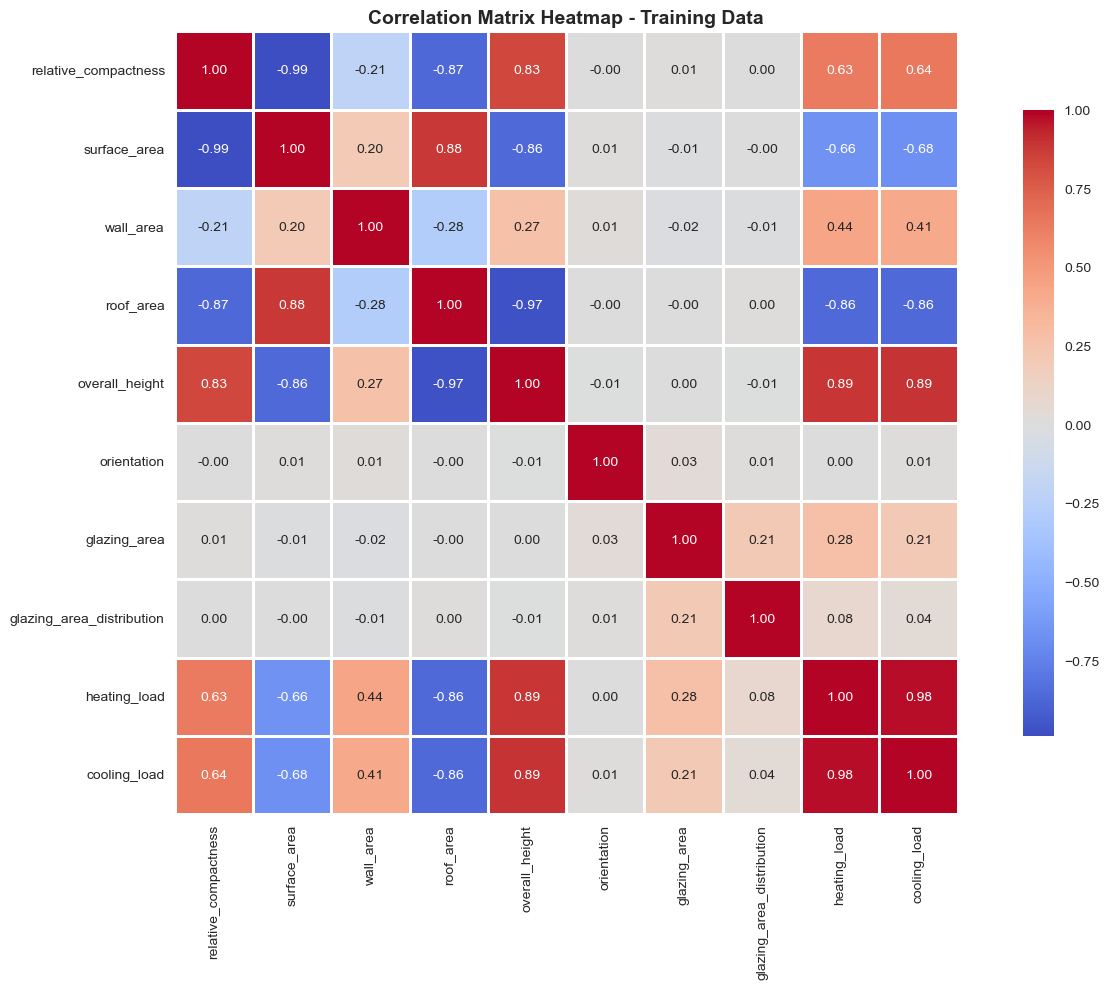

In [5]:
# Correlation matrix heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap - Training Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


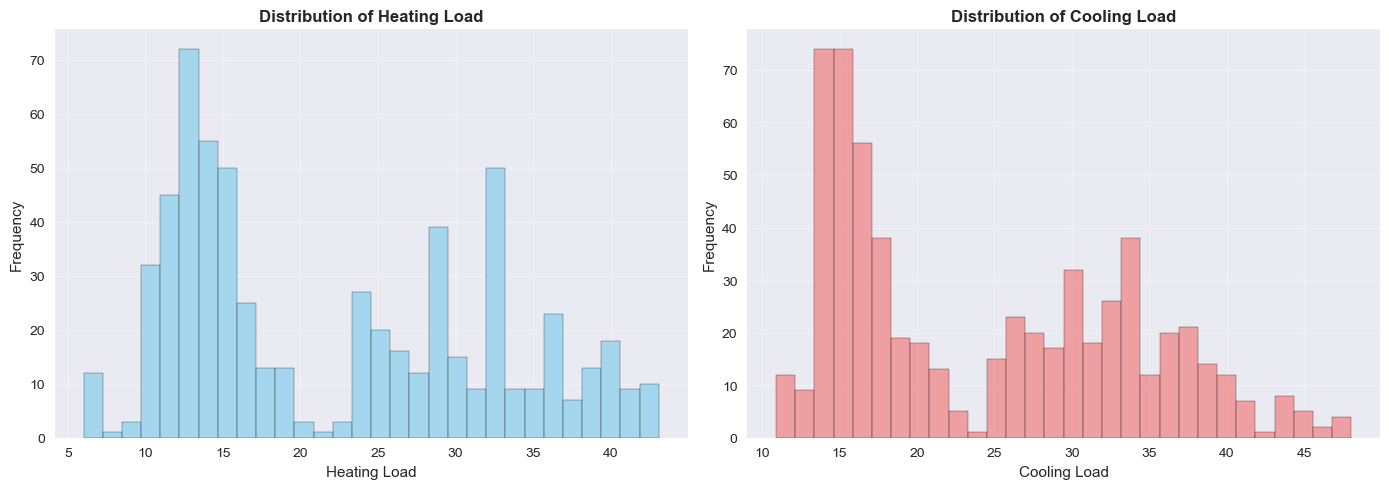

In [6]:
# Distribution of target variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train_heating, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Distribution of Heating Load', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Heating Load')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_train_cooling, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_title('Distribution of Cooling Load', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cooling Load')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/target_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Preprocessing and Helper Functions


In [7]:
# Define helper function for metrics calculation
def calculate_metrics(y_true, y_pred):
    """Calculate regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R²': r2}

# Define helper function for cross-validation scoring
def cv_regression_metrics(model, X, y, cv=5):
    """Perform cross-validation and return metrics"""
    kfold = KFold(n_splits=cv, shuffle=True, random_state=RND)
    
    mse_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    rmse_scores = np.sqrt(mse_scores)
    
    return {
        'MSE': (mse_scores.mean(), mse_scores.std()),
        'MAE': (mae_scores.mean(), mae_scores.std()),
        'RMSE': (rmse_scores.mean(), rmse_scores.std()),
        'R²': (r2_scores.mean(), r2_scores.std())
    }


## 4. Train Two Linear Regression Models


In [8]:
# Create pipelines for both models
pipeline_heating = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pipeline_cooling = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

print("=== Model 1: Heating Load - Cross-Validation Results ===")
cv_results_heating = cv_regression_metrics(pipeline_heating, X_train, y_train_heating, cv=5)
for metric, (mean, std) in cv_results_heating.items():
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

print("\n=== Model 2: Cooling Load - Cross-Validation Results ===")
cv_results_cooling = cv_regression_metrics(pipeline_cooling, X_train, y_train_cooling, cv=5)
for metric, (mean, std) in cv_results_cooling.items():
    print(f"{metric}: {mean:.4f} ± {std:.4f}")


=== Model 1: Heating Load - Cross-Validation Results ===
MSE: 8.5273 ± 0.9352
MAE: 2.0618 ± 0.0950
RMSE: 2.9158 ± 0.1590
R²: 0.9146 ± 0.0109

=== Model 2: Cooling Load - Cross-Validation Results ===
MSE: 10.4189 ± 1.1782
MAE: 2.2773 ± 0.1702
RMSE: 3.2229 ± 0.1777
R²: 0.8829 ± 0.0119


In [9]:
# Fit final models on full training set
print("Fitting final models on full training set...")
pipeline_heating.fit(X_train, y_train_heating)
pipeline_cooling.fit(X_train, y_train_cooling)

# Save models
joblib.dump(pipeline_heating, 'model1_2.pkl')
joblib.dump(pipeline_cooling, 'model2_2.pkl')
print("Models saved successfully:")
print("  - model1_2.pkl (Heating Load)")
print("  - model2_2.pkl (Cooling Load)")


Fitting final models on full training set...
Models saved successfully:
  - model1_2.pkl (Heating Load)
  - model2_2.pkl (Cooling Load)


## 5. Load Models & Predict on Test Set


In [10]:
# Load models to demonstrate persistence
loaded_model1 = joblib.load('model1_2.pkl')
loaded_model2 = joblib.load('model2_2.pkl')
print("Models loaded successfully!")

# Make predictions
y_pred_heating = loaded_model1.predict(X_test)
y_pred_cooling = loaded_model2.predict(X_test)

# Store predictions in dataframes
predictions_df = pd.DataFrame({
    'true_heating': y_test_heating.values,
    'pred_heating': y_pred_heating,
    'true_cooling': y_test_cooling.values,
    'pred_cooling': y_pred_cooling
})

print("\nPredictions dataframe shape:", predictions_df.shape)
print("\nFirst few predictions:")
print(predictions_df.head())


Models loaded successfully!

Predictions dataframe shape: (154, 4)

First few predictions:
   true_heating  pred_heating  true_cooling  pred_cooling
0         16.47     18.862960         16.90     19.754556
1         13.17     14.049380         16.39     16.771609
2         32.82     31.315603         32.78     32.024977
3         41.32     35.900510         46.23     36.702408
4         16.69     15.335197         19.76     17.276704


## 6. Visualization: Regression Plots


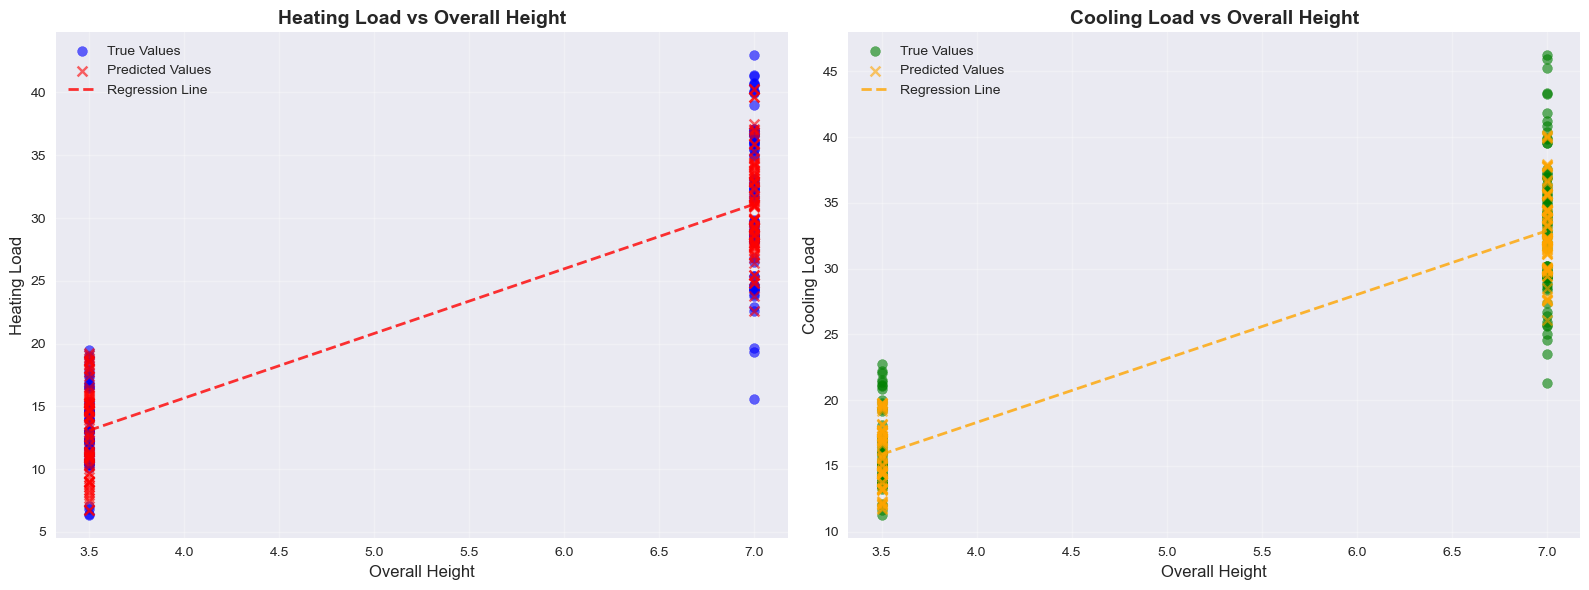

In [11]:
# Plot 1: Heating Load vs Overall Height
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heating Load vs Overall Height
axes[0].scatter(X_test['overall_height'], y_test_heating, alpha=0.6, label='True Values', color='blue', s=50)
axes[0].scatter(X_test['overall_height'], y_pred_heating, alpha=0.6, label='Predicted Values', color='red', s=50, marker='x')

# Fit a regression line for predictions
z_heating = np.polyfit(X_test['overall_height'], y_pred_heating, 1)
p_heating = np.poly1d(z_heating)
axes[0].plot(X_test['overall_height'].sort_values(), p_heating(X_test['overall_height'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label='Regression Line')

axes[0].set_xlabel('Overall Height', fontsize=12)
axes[0].set_ylabel('Heating Load', fontsize=12)
axes[0].set_title('Heating Load vs Overall Height', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cooling Load vs Overall Height
axes[1].scatter(X_test['overall_height'], y_test_cooling, alpha=0.6, label='True Values', color='green', s=50)
axes[1].scatter(X_test['overall_height'], y_pred_cooling, alpha=0.6, label='Predicted Values', color='orange', s=50, marker='x')

# Fit a regression line for predictions
z_cooling = np.polyfit(X_test['overall_height'], y_pred_cooling, 1)
p_cooling = np.poly1d(z_cooling)
axes[1].plot(X_test['overall_height'].sort_values(), p_cooling(X_test['overall_height'].sort_values()), 
             "orange", linestyle='--', alpha=0.8, linewidth=2, label='Regression Line')

axes[1].set_xlabel('Overall Height', fontsize=12)
axes[1].set_ylabel('Cooling Load', fontsize=12)
axes[1].set_title('Cooling Load vs Overall Height', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/regression_plots_overall_height.png', dpi=300, bbox_inches='tight')
plt.show()


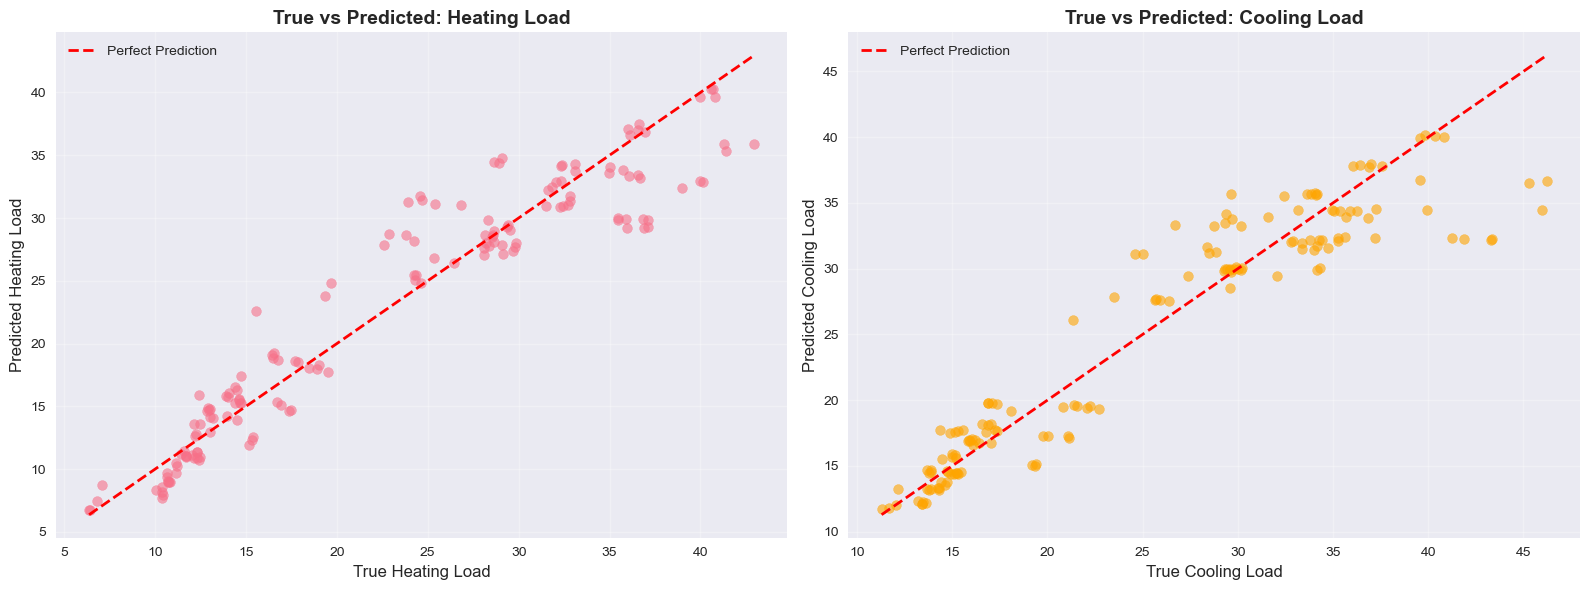

In [12]:
# Additional plot: True vs Predicted scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heating Load: True vs Predicted
axes[0].scatter(y_test_heating, y_pred_heating, alpha=0.6, s=50)
min_val = min(y_test_heating.min(), y_pred_heating.min())
max_val = max(y_test_heating.max(), y_pred_heating.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('True Heating Load', fontsize=12)
axes[0].set_ylabel('Predicted Heating Load', fontsize=12)
axes[0].set_title('True vs Predicted: Heating Load', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cooling Load: True vs Predicted
axes[1].scatter(y_test_cooling, y_pred_cooling, alpha=0.6, s=50, color='orange')
min_val = min(y_test_cooling.min(), y_pred_cooling.min())
max_val = max(y_test_cooling.max(), y_pred_cooling.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('True Cooling Load', fontsize=12)
axes[1].set_ylabel('Predicted Cooling Load', fontsize=12)
axes[1].set_title('True vs Predicted: Cooling Load', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/true_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Evaluation on Test Data


In [13]:
# Calculate metrics for both models
metrics_heating = calculate_metrics(y_test_heating, y_pred_heating)
metrics_cooling = calculate_metrics(y_test_cooling, y_pred_cooling)

# Create results table
results_table = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression'],
    'Target': ['Heating Load', 'Cooling Load'],
    'MSE': [metrics_heating['MSE'], metrics_cooling['MSE']],
    'MAE': [metrics_heating['MAE'], metrics_cooling['MAE']],
    'RMSE': [metrics_heating['RMSE'], metrics_cooling['RMSE']],
    'MAPE': [metrics_heating['MAPE'], metrics_cooling['MAPE']],
    'R²': [metrics_heating['R²'], metrics_cooling['R²']]
})

print("=== Test Set Evaluation Results ===")
print(results_table.to_string(index=False))

# Save results table
results_table.to_csv('linear_regression_results.csv', index=False)
print("\nResults saved to linear_regression_results.csv")


=== Test Set Evaluation Results ===
            Model       Target      MSE      MAE     RMSE      MAPE       R²
Linear Regression Heating Load 9.153188 2.182047 3.025424 10.258458 0.912184
Linear Regression Cooling Load 9.893428 2.195295 3.145382  8.478724 0.893226

Results saved to linear_regression_results.csv


## 8. Feature Influence Analysis


In [14]:
# Calculate Pearson correlations
correlations_heating = {}
correlations_cooling = {}

for feature in feature_cols:
    corr_heating, p_val_heating = pearsonr(X_train[feature], y_train_heating)
    corr_cooling, p_val_cooling = pearsonr(X_train[feature], y_train_cooling)
    correlations_heating[feature] = corr_heating
    correlations_cooling[feature] = corr_cooling

# Create correlation dataframe
corr_df = pd.DataFrame({
    'Feature': feature_cols,
    'Heating_Load_Correlation': [correlations_heating[f] for f in feature_cols],
    'Cooling_Load_Correlation': [correlations_cooling[f] for f in feature_cols]
})

print("=== Feature Correlations with Targets ===")
print(corr_df.to_string(index=False))

# Get coefficients from linear regression models
scaler_heating = pipeline_heating.named_steps['scaler']
model_heating = pipeline_heating.named_steps['model']

scaler_cooling = pipeline_cooling.named_steps['scaler']
model_cooling = pipeline_cooling.named_steps['model']

coefficients_heating = model_heating.coef_
coefficients_cooling = model_cooling.coef_

coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Heating_Load_Coefficient': coefficients_heating,
    'Cooling_Load_Coefficient': coefficients_cooling
})

print("\n=== Linear Regression Coefficients ===")
print(coef_df.to_string(index=False))


=== Feature Correlations with Targets ===
                  Feature  Heating_Load_Correlation  Cooling_Load_Correlation
     relative_compactness                  0.629314                  0.642148
             surface_area                 -0.664684                 -0.679988
                wall_area                  0.439092                  0.410905
                roof_area                 -0.863294                 -0.864714
           overall_height                  0.889154                  0.894927
              orientation                  0.001772                  0.008773
             glazing_area                  0.276184                  0.212642
glazing_area_distribution                  0.080206                  0.041308

=== Linear Regression Coefficients ===
                  Feature  Heating_Load_Coefficient  Cooling_Load_Coefficient
     relative_compactness                 -6.517601                 -7.487886
             surface_area                 -3.604586         

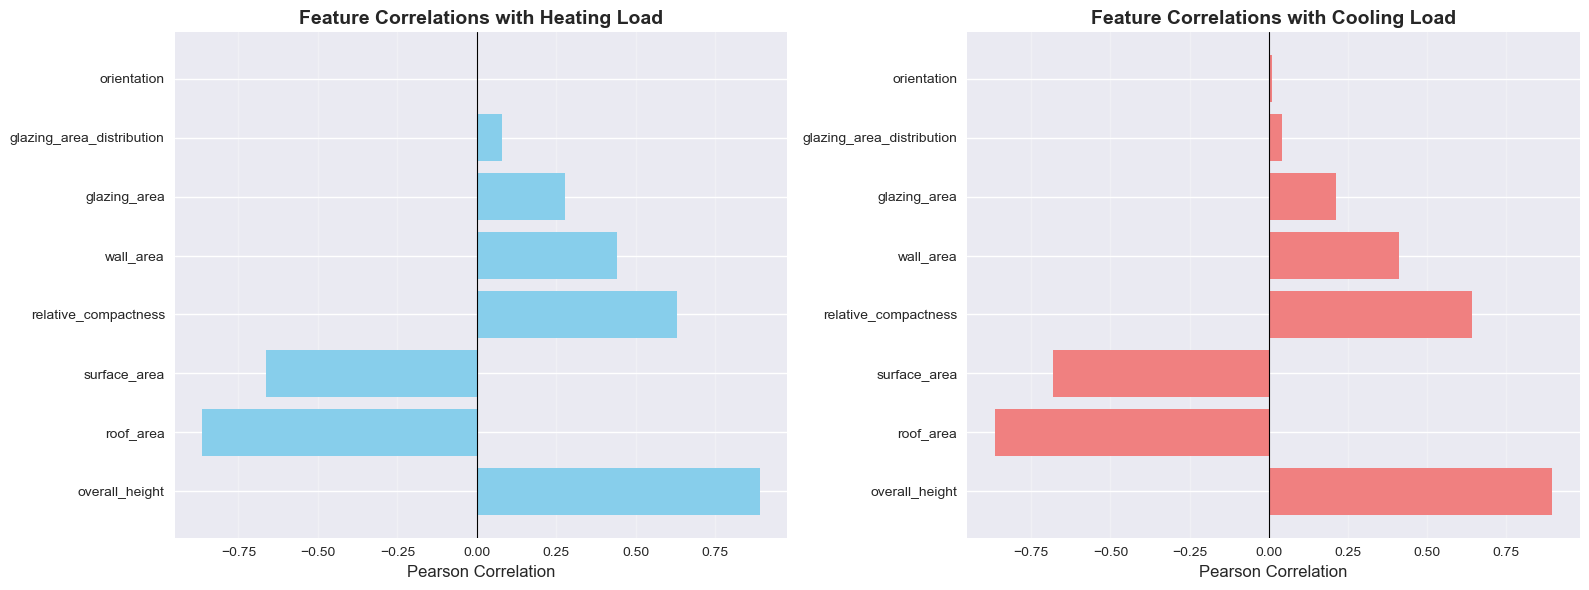

In [15]:
# Visualization: Correlation heatmap for features vs targets
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heating Load correlations
heating_corr = corr_df.sort_values('Heating_Load_Correlation', key=abs, ascending=False)
axes[0].barh(heating_corr['Feature'], heating_corr['Heating_Load_Correlation'], color='skyblue')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel('Pearson Correlation', fontsize=12)
axes[0].set_title('Feature Correlations with Heating Load', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Cooling Load correlations
cooling_corr = corr_df.sort_values('Cooling_Load_Correlation', key=abs, ascending=False)
axes[1].barh(cooling_corr['Feature'], cooling_corr['Cooling_Load_Correlation'], color='lightcoral')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Pearson Correlation', fontsize=12)
axes[1].set_title('Feature Correlations with Cooling Load', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()


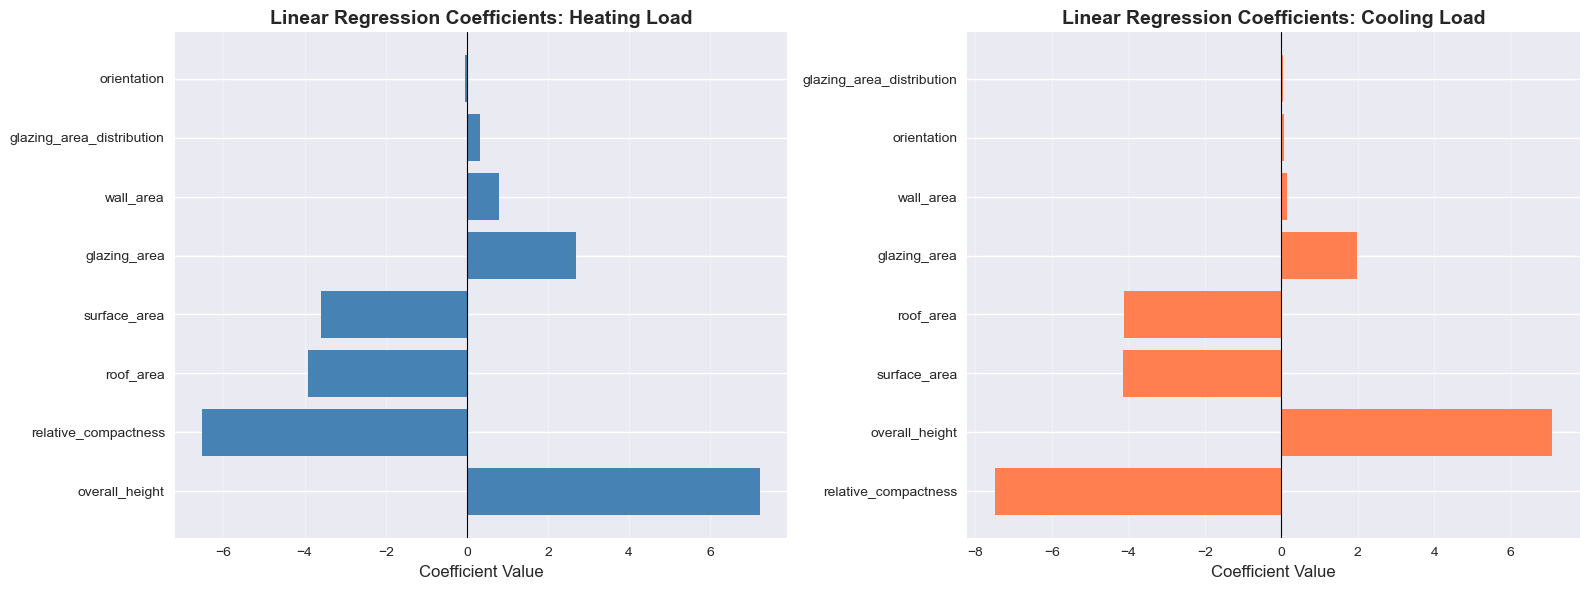

In [16]:
# Visualization: Feature coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heating Load coefficients
heating_coef = coef_df.sort_values('Heating_Load_Coefficient', key=abs, ascending=False)
axes[0].barh(heating_coef['Feature'], heating_coef['Heating_Load_Coefficient'], color='steelblue')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel('Coefficient Value', fontsize=12)
axes[0].set_title('Linear Regression Coefficients: Heating Load', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Cooling Load coefficients
cooling_coef = coef_df.sort_values('Cooling_Load_Coefficient', key=abs, ascending=False)
axes[1].barh(cooling_coef['Feature'], cooling_coef['Cooling_Load_Coefficient'], color='coral')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].set_title('Linear Regression Coefficients: Cooling Load', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Compare with Other Regression Techniques


In [17]:
# Initialize results storage
all_results = []

# Helper function to train and evaluate a model
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, target_name):
    """Train model, perform CV, and evaluate on test set"""
    # Cross-validation
    cv_metrics = cv_regression_metrics(model, X_train, y_train, cv=5)
    
    # Fit on full training set
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate test metrics
    test_metrics = calculate_metrics(y_test, y_pred)
    
    return {
        'model_name': model_name,
        'target': target_name,
        'cv_r2_mean': cv_metrics['R²'][0],
        'cv_r2_std': cv_metrics['R²'][1],
        **test_metrics,
        'model': model,
        'predictions': y_pred
    }


### 9.1 Polynomial Regression


In [18]:
# Tune degree via cross-validation
degrees = [2, 3]
best_degree_heating = 2
best_degree_cooling = 2
best_cv_r2_heating = -np.inf
best_cv_r2_cooling = -np.inf

for degree in degrees:
    poly_pipeline_heating = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])
    
    poly_pipeline_cooling = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])
    
    cv_r2_heating = cv_regression_metrics(poly_pipeline_heating, X_train, y_train_heating, cv=5)['R²'][0]
    cv_r2_cooling = cv_regression_metrics(poly_pipeline_cooling, X_train, y_train_cooling, cv=5)['R²'][0]
    
    if cv_r2_heating > best_cv_r2_heating:
        best_cv_r2_heating = cv_r2_heating
        best_degree_heating = degree
    
    if cv_r2_cooling > best_cv_r2_cooling:
        best_cv_r2_cooling = cv_r2_cooling
        best_degree_cooling = degree

print(f"Best degree for Heating Load: {best_degree_heating}")
print(f"Best degree for Cooling Load: {best_degree_cooling}")

poly_pipeline_heating = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree_heating)),
    ('model', LinearRegression())
])

poly_pipeline_cooling = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree_cooling)),
    ('model', LinearRegression())
])

poly_results_heating = train_and_evaluate_model(
    poly_pipeline_heating, 'Polynomial Regression', X_train, y_train_heating, X_test, y_test_heating, 'Heating Load'
)
poly_results_heating['hyperparameters'] = f'degree={best_degree_heating}'

poly_results_cooling = train_and_evaluate_model(
    poly_pipeline_cooling, 'Polynomial Regression', X_train, y_train_cooling, X_test, y_test_cooling, 'Cooling Load'
)
poly_results_cooling['hyperparameters'] = f'degree={best_degree_cooling}'

all_results.append(poly_results_heating)
all_results.append(poly_results_cooling)


Best degree for Heating Load: 3
Best degree for Cooling Load: 3


### 9.2 Ridge Regression


In [19]:
# Tune alpha via grid search
alphas_ridge = [0.01, 0.1, 1, 10, 100]

ridge_pipeline_heating = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=RND))
])

ridge_pipeline_cooling = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=RND))
])

grid_ridge_heating = GridSearchCV(ridge_pipeline_heating, 
                                  {'model__alpha': alphas_ridge}, 
                                  cv=5, scoring='r2', n_jobs=-1)
grid_ridge_heating.fit(X_train, y_train_heating)

grid_ridge_cooling = GridSearchCV(ridge_pipeline_cooling, 
                                  {'model__alpha': alphas_ridge}, 
                                  cv=5, scoring='r2', n_jobs=-1)
grid_ridge_cooling.fit(X_train, y_train_cooling)

best_alpha_heating = grid_ridge_heating.best_params_['model__alpha']
best_alpha_cooling = grid_ridge_cooling.best_params_['model__alpha']

print(f"Best alpha for Heating Load: {best_alpha_heating}")
print(f"Best alpha for Cooling Load: {best_alpha_cooling}")

ridge_results_heating = train_and_evaluate_model(
    grid_ridge_heating.best_estimator_, 'Ridge Regression', X_train, y_train_heating, 
    X_test, y_test_heating, 'Heating Load'
)
ridge_results_heating['hyperparameters'] = f'alpha={best_alpha_heating}'

ridge_results_cooling = train_and_evaluate_model(
    grid_ridge_cooling.best_estimator_, 'Ridge Regression', X_train, y_train_cooling, 
    X_test, y_test_cooling, 'Cooling Load'
)
ridge_results_cooling['hyperparameters'] = f'alpha={best_alpha_cooling}'

all_results.append(ridge_results_heating)
all_results.append(ridge_results_cooling)


Best alpha for Heating Load: 0.1
Best alpha for Cooling Load: 0.1


### 9.3 Lasso Regression


In [20]:
alphas_lasso = [0.01, 0.1, 1, 10, 100]

lasso_pipeline_heating = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=RND, max_iter=2000))
])

lasso_pipeline_cooling = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=RND, max_iter=2000))
])

grid_lasso_heating = GridSearchCV(lasso_pipeline_heating, 
                                  {'model__alpha': alphas_lasso}, 
                                  cv=5, scoring='r2', n_jobs=-1)
grid_lasso_heating.fit(X_train, y_train_heating)

grid_lasso_cooling = GridSearchCV(lasso_pipeline_cooling, 
                                  {'model__alpha': alphas_lasso}, 
                                  cv=5, scoring='r2', n_jobs=-1)
grid_lasso_cooling.fit(X_train, y_train_cooling)

best_alpha_lasso_heating = grid_lasso_heating.best_params_['model__alpha']
best_alpha_lasso_cooling = grid_lasso_cooling.best_params_['model__alpha']

print(f"Best alpha for Heating Load: {best_alpha_lasso_heating}")
print(f"Best alpha for Cooling Load: {best_alpha_lasso_cooling}")

lasso_results_heating = train_and_evaluate_model(
    grid_lasso_heating.best_estimator_, 'Lasso Regression', X_train, y_train_heating, 
    X_test, y_test_heating, 'Heating Load'
)
lasso_results_heating['hyperparameters'] = f'alpha={best_alpha_lasso_heating}'

lasso_results_cooling = train_and_evaluate_model(
    grid_lasso_cooling.best_estimator_, 'Lasso Regression', X_train, y_train_cooling, 
    X_test, y_test_cooling, 'Cooling Load'
)
lasso_results_cooling['hyperparameters'] = f'alpha={best_alpha_lasso_cooling}'

all_results.append(lasso_results_heating)
all_results.append(lasso_results_cooling)


Best alpha for Heating Load: 0.01
Best alpha for Cooling Load: 0.01


### 9.4 Support Vector Regression (SVR)


In [21]:
svr_pipeline_heating = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf'))
])

svr_pipeline_cooling = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf'))
])

# Tune hyperparameters
param_grid_svr = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 'auto', 0.001, 0.01],
    'model__epsilon': [0.01, 0.1, 0.5, 1.0]
}

print("Performing grid search for Heating Load (this may take a while)...")
grid_svr_heating = GridSearchCV(svr_pipeline_heating, param_grid_svr, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_svr_heating.fit(X_train, y_train_heating)

print("Performing grid search for Cooling Load (this may take a while)...")
grid_svr_cooling = GridSearchCV(svr_pipeline_cooling, param_grid_svr, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_svr_cooling.fit(X_train, y_train_cooling)

best_params_heating = grid_svr_heating.best_params_
best_params_cooling = grid_svr_cooling.best_params_

print(f"\nBest SVR params for Heating Load: {best_params_heating}")
print(f"Best SVR params for Cooling Load: {best_params_cooling}")

svr_results_heating = train_and_evaluate_model(
    grid_svr_heating.best_estimator_, 'SVR', X_train, y_train_heating, 
    X_test, y_test_heating, 'Heating Load'
)
svr_results_heating['hyperparameters'] = f"C={best_params_heating['model__C']}, gamma={best_params_heating['model__gamma']}, epsilon={best_params_heating['model__epsilon']}"

svr_results_cooling = train_and_evaluate_model(
    grid_svr_cooling.best_estimator_, 'SVR', X_train, y_train_cooling, 
    X_test, y_test_cooling, 'Cooling Load'
)
svr_results_cooling['hyperparameters'] = f"C={best_params_cooling['model__C']}, gamma={best_params_cooling['model__gamma']}, epsilon={best_params_cooling['model__epsilon']}"

all_results.append(svr_results_heating)
all_results.append(svr_results_cooling)


Performing grid search for Heating Load (this may take a while)...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Performing grid search for Cooling Load (this may take a while)...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best SVR params for Heating Load: {'model__C': 100, 'model__epsilon': 0.1, 'model__gamma': 'scale'}
Best SVR params for Cooling Load: {'model__C': 100, 'model__epsilon': 0.1, 'model__gamma': 'scale'}


### 9.5 Complete Model Comparison


In [22]:
# Add linear regression results to comparison
linear_results_heating = train_and_evaluate_model(
    pipeline_heating, 'Linear Regression', X_train, y_train_heating, 
    X_test, y_test_heating, 'Heating Load'
)
linear_results_heating['hyperparameters'] = 'None'

linear_results_cooling = train_and_evaluate_model(
    pipeline_cooling, 'Linear Regression', X_train, y_train_cooling, 
    X_test, y_test_cooling, 'Cooling Load'
)
linear_results_cooling['hyperparameters'] = 'None'

all_results.append(linear_results_heating)
all_results.append(linear_results_cooling)

# Create comprehensive results table
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Target': r['target'],
        'MSE': r['MSE'],
        'MAE': r['MAE'],
        'RMSE': r['RMSE'],
        'MAPE': r['MAPE'],
        'R²': r['R²'],
        'Hyperparameters': r.get('hyperparameters', 'N/A')
    }
    for r in all_results
])

print("=== Complete Model Comparison Results ===")
print(comparison_df.to_string(index=False))

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to model_comparison_results.csv")


=== Complete Model Comparison Results ===
                Model       Target      MSE      MAE     RMSE      MAPE       R²                 Hyperparameters
Polynomial Regression Heating Load 0.293476 0.410768 0.541735  2.022542 0.997184                        degree=3
Polynomial Regression Cooling Load 2.777063 1.194663 1.666452  4.553266 0.970029                        degree=3
     Ridge Regression Heating Load 9.158899 2.182872 3.026367 10.268057 0.912129                       alpha=0.1
     Ridge Regression Cooling Load 9.895537 2.194880 3.145717  8.485909 0.893203                       alpha=0.1
     Lasso Regression Heating Load 9.246878 2.204940 3.040868 10.448456 0.911285                      alpha=0.01
     Lasso Regression Cooling Load 9.937215 2.195326 3.152335  8.579176 0.892753                      alpha=0.01
                  SVR Heating Load 0.539790 0.561422 0.734704  2.922454 0.994821 C=100, gamma=scale, epsilon=0.1
                  SVR Cooling Load 3.191717 1.136930 1

## 10. Visualization: Model Comparisons


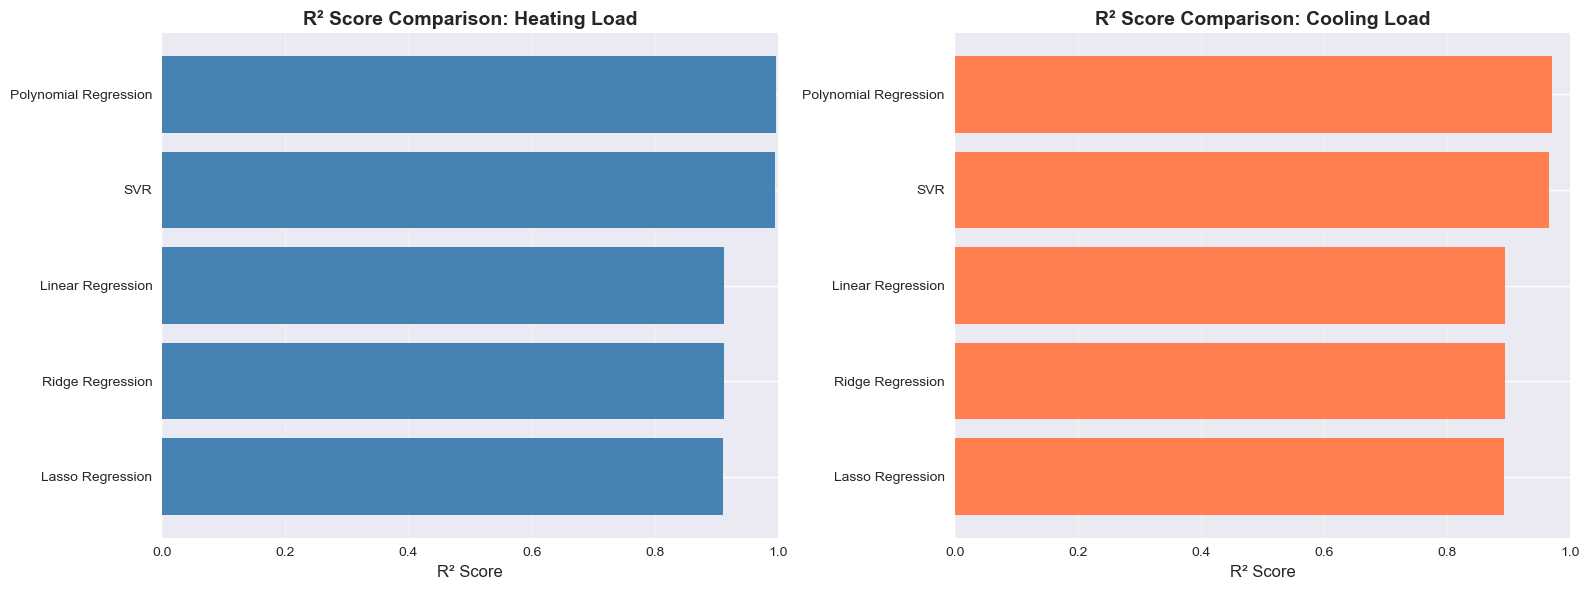

In [23]:
# R² comparison across all models
heating_results = comparison_df[comparison_df['Target'] == 'Heating Load'].copy()
cooling_results = comparison_df[comparison_df['Target'] == 'Cooling Load'].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heating Load R² comparison
heating_results_sorted = heating_results.sort_values('R²', ascending=True)
axes[0].barh(heating_results_sorted['Model'], heating_results_sorted['R²'], color='steelblue')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison: Heating Load', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].set_xlim([0, 1])

# Cooling Load R² comparison
cooling_results_sorted = cooling_results.sort_values('R²', ascending=True)
axes[1].barh(cooling_results_sorted['Model'], cooling_results_sorted['R²'], color='coral')
axes[1].set_xlabel('R² Score', fontsize=12)
axes[1].set_title('R² Score Comparison: Cooling Load', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig('figures/r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


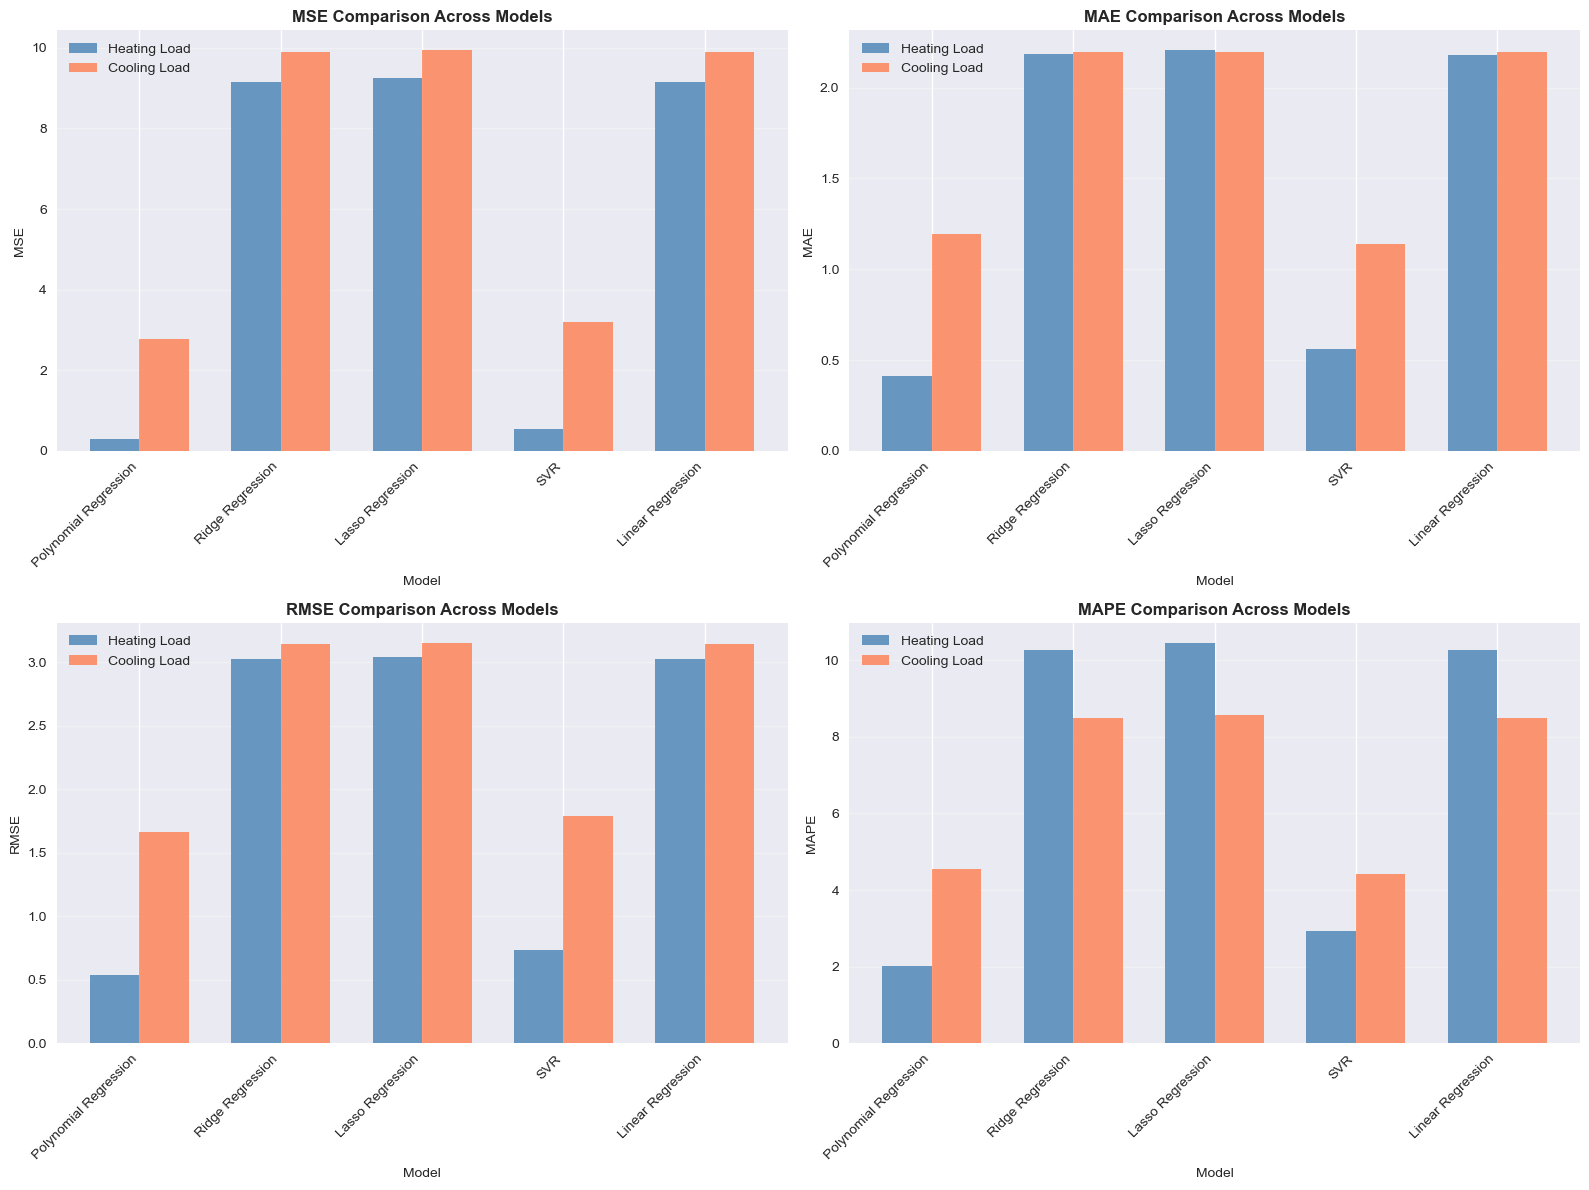

In [24]:
# Error comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['MSE', 'MAE', 'RMSE', 'MAPE']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    
    heating_vals = heating_results[metric].values
    cooling_vals = cooling_results[metric].values
    models = heating_results['Model'].values
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[row, col].bar(x - width/2, heating_vals, width, label='Heating Load', color='steelblue', alpha=0.8)
    axes[row, col].bar(x + width/2, cooling_vals, width, label='Cooling Load', color='coral', alpha=0.8)
    
    axes[row, col].set_xlabel('Model', fontsize=10)
    axes[row, col].set_ylabel(metric, fontsize=10)
    axes[row, col].set_title(f'{metric} Comparison Across Models', fontsize=12, fontweight='bold')
    axes[row, col].set_xticks(x)
    axes[row, col].set_xticklabels(models, rotation=45, ha='right')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/error_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### 10.1 Learning Curves 


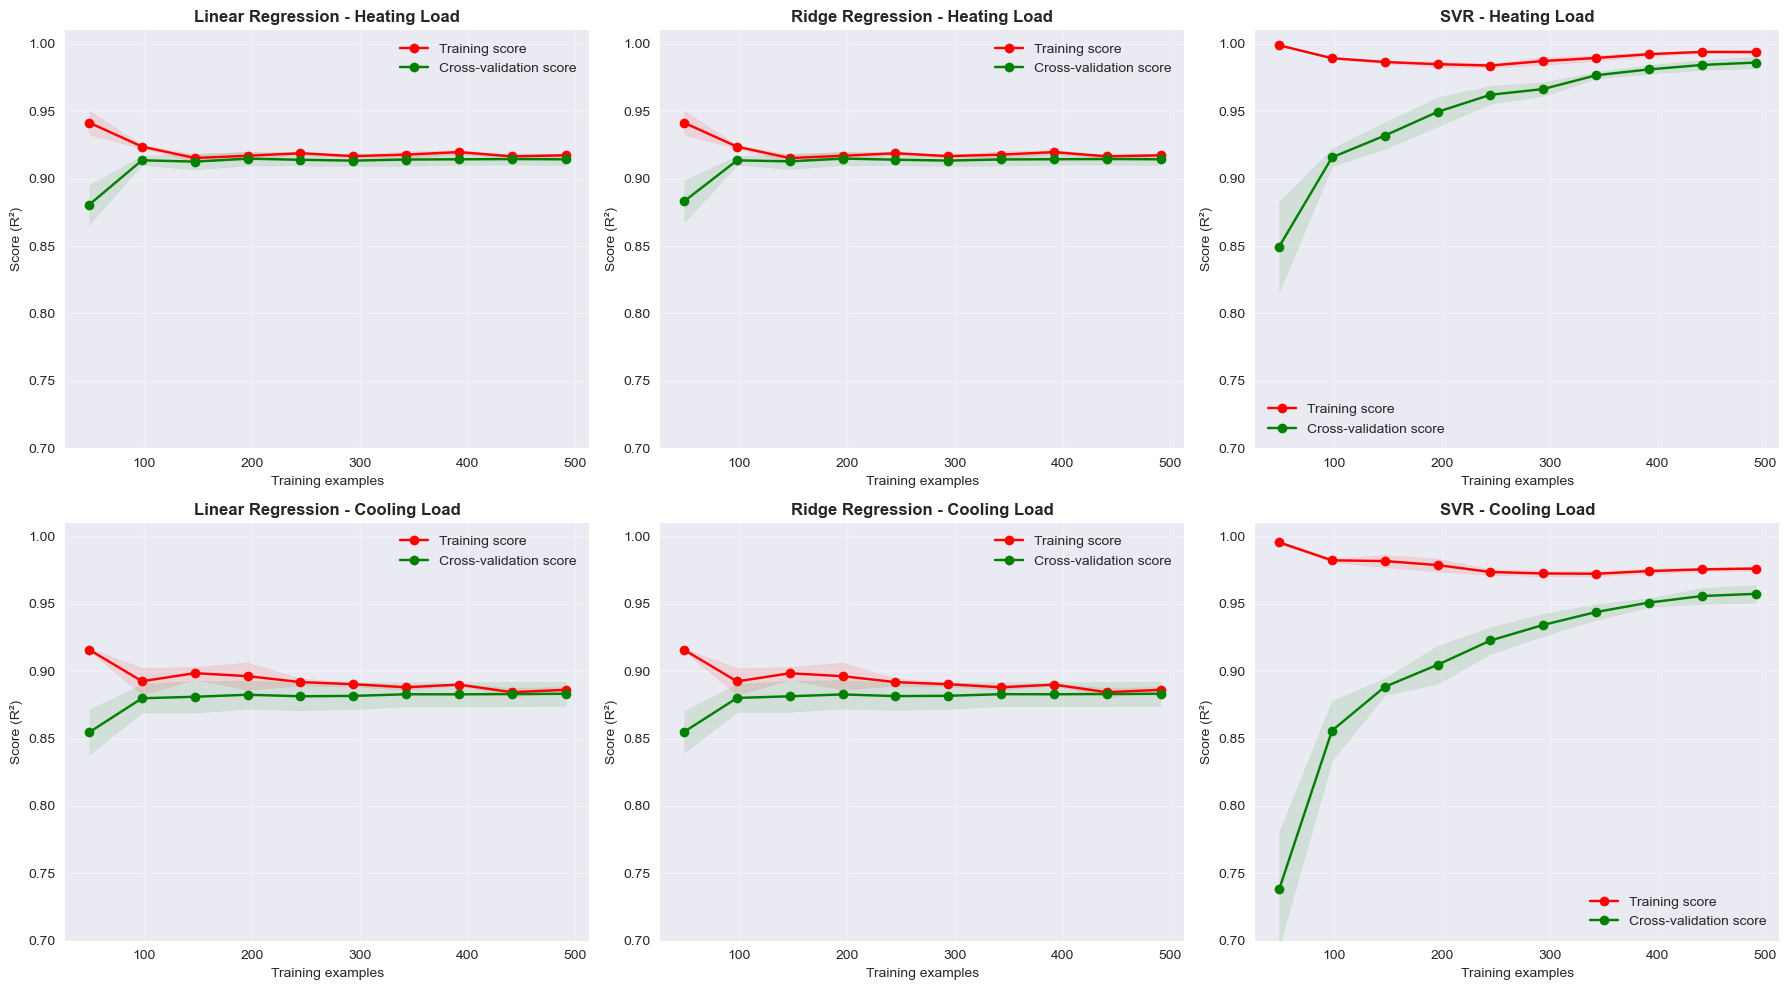

In [25]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """Generate learning curves for a model"""
    axes.set_title(title, fontsize=12, fontweight='bold')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples", fontsize=10)
    axes.set_ylabel("Score (R²)", fontsize=10)
    
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    axes.grid(True, alpha=0.3)
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")
    
    return axes

# Plot learning curves for selected models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Linear Regression - Heating
plot_learning_curve(pipeline_heating, "Linear Regression - Heating Load", 
                    X_train, y_train_heating, axes[0, 0], ylim=(0.7, 1.01))

# Ridge Regression - Heating
plot_learning_curve(grid_ridge_heating.best_estimator_, "Ridge Regression - Heating Load", 
                    X_train, y_train_heating, axes[0, 1], ylim=(0.7, 1.01))

# SVR - Heating
plot_learning_curve(grid_svr_heating.best_estimator_, "SVR - Heating Load", 
                    X_train, y_train_heating, axes[0, 2], ylim=(0.7, 1.01))

# Linear Regression - Cooling
plot_learning_curve(pipeline_cooling, "Linear Regression - Cooling Load", 
                    X_train, y_train_cooling, axes[1, 0], ylim=(0.7, 1.01))

# Ridge Regression - Cooling
plot_learning_curve(grid_ridge_cooling.best_estimator_, "Ridge Regression - Cooling Load", 
                    X_train, y_train_cooling, axes[1, 1], ylim=(0.7, 1.01))

# SVR - Cooling
plot_learning_curve(grid_svr_cooling.best_estimator_, "SVR - Cooling Load", 
                    X_train, y_train_cooling, axes[1, 2], ylim=(0.7, 1.01))

plt.tight_layout()
plt.savefig('figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()


## 11. Summary and Analysis


In [26]:
# Print summary statistics
print("=== BEST MODELS ===")
print("\nHeating Load:")
best_heating = heating_results.loc[heating_results['R²'].idxmax()]
print(f"  Best Model: {best_heating['Model']}")
print(f"  R² Score: {best_heating['R²']:.4f}")
print(f"  RMSE: {best_heating['RMSE']:.4f}")
print(f"  Hyperparameters: {best_heating['Hyperparameters']}")

print("\nCooling Load:")
best_cooling = cooling_results.loc[cooling_results['R²'].idxmax()]
print(f"  Best Model: {best_cooling['Model']}")
print(f"  R² Score: {best_cooling['R²']:.4f}")
print(f"  RMSE: {best_cooling['RMSE']:.4f}")
print(f"  Hyperparameters: {best_cooling['Hyperparameters']}")

print("\n=== FEATURE IMPORTANCE SUMMARY ===")
print("\nTop 3 features for Heating Load (by correlation):")
top_heating = corr_df.nlargest(3, 'Heating_Load_Correlation', keep='all')
for _, row in top_heating.iterrows():
    print(f"  {row['Feature']}: {row['Heating_Load_Correlation']:.4f}")

print("\nTop 3 features for Cooling Load (by correlation):")
top_cooling = corr_df.nlargest(3, 'Cooling_Load_Correlation', keep='all')
for _, row in top_cooling.iterrows():
    print(f"  {row['Feature']}: {row['Cooling_Load_Correlation']:.4f}")


=== BEST MODELS ===

Heating Load:
  Best Model: Polynomial Regression
  R² Score: 0.9972
  RMSE: 0.5417
  Hyperparameters: degree=3

Cooling Load:
  Best Model: Polynomial Regression
  R² Score: 0.9700
  RMSE: 1.6665
  Hyperparameters: degree=3

=== FEATURE IMPORTANCE SUMMARY ===

Top 3 features for Heating Load (by correlation):
  overall_height: 0.8892
  relative_compactness: 0.6293
  wall_area: 0.4391

Top 3 features for Cooling Load (by correlation):
  overall_height: 0.8949
  relative_compactness: 0.6421
  wall_area: 0.4109
